<a href="https://colab.research.google.com/github/priya170807/text_analysis/blob/master/enc_dec_teacherforcing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0
time: 9.17 ms (started: 2021-01-04 06:39:45 +00:00)


In [85]:
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

tf version:  2.4.0
tf.keras version: 2.4.0
time: 2.21 ms (started: 2021-01-04 06:39:45 +00:00)


In [86]:
!pip install ipython-autotime

%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.27 s (started: 2021-01-04 06:39:45 +00:00)


In [87]:
from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

time: 8.42 ms (started: 2021-01-04 06:39:48 +00:00)


In [88]:
def generate_sequence(length, n_unique):
  vector = [randint(0, n_unique-1) for _ in range(length)]
  # print(vector)
  return vector

# one hot encode sequence
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)

time: 8.88 ms (started: 2021-01-04 06:39:48 +00:00)


In [89]:
# decode a one hot encoded string
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]

# prepare data for the LSTM
def get_reversed_pairs(time_steps,vocabulary_size,verbose= True):
  # generate random sequence
  sequence_in = generate_sequence(time_steps, vocabulary_size)
  print("sequence_in = {}".format(sequence_in))
  sequence_out = sequence_in[::-1]
  print("sequence_out = {}".format(sequence_out))

  # one hot encode
  X = one_hot_encode(sequence_in, vocabulary_size)
  y = one_hot_encode(sequence_out, vocabulary_size)
  # reshape as 3D
  X = X.reshape((1, X.shape[0], X.shape[1]))
  y = y.reshape((1, y.shape[0], y.shape[1]))

  if(verbose):
    print('\nSample X and y')
    print('\nIn raw format:')
    print('X=%s, y=%s' % (one_hot_decode(X[0]), one_hot_decode(y[0])))
    print('\nIn one_hot_encoded format:')
    print('X=%s' % (X[0]))
    print('y=%s' % (y[0]))
  return X,y


time: 16.7 ms (started: 2021-01-04 06:39:48 +00:00)


In [90]:
vocabulary_size=10
time_steps=4
train_size=2
pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]

sequence_in = [1, 3, 0, 8]
sequence_out = [8, 0, 3, 1]

Sample X and y

In raw format:
X=[1, 3, 0, 8], y=[8, 0, 3, 1]

In one_hot_encoded format:
X=[[0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]]
y=[[0 0 0 0 0 0 0 0 1 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]]
sequence_in = [7, 2, 1, 2]
sequence_out = [2, 1, 2, 7]

Sample X and y

In raw format:
X=[7, 2, 1, 2], y=[2, 1, 2, 7]

In one_hot_encoded format:
X=[[0 0 0 0 0 0 0 1 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]]
y=[[0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]]
time: 6.97 ms (started: 2021-01-04 06:39:48 +00:00)


In [91]:
pairs

[(array([[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]]),
  array([[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
          [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]])),
 (array([[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
          [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
          [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]]),
  array([[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
          [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]]))]

time: 5.77 ms (started: 2021-01-04 06:39:48 +00:00)


In [92]:
k1 = np.array(pairs)

time: 525 µs (started: 2021-01-04 06:39:48 +00:00)


In [93]:
k1

array([[[[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]]],


        [[[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
          [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
          [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]]],



       [[[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
          [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
          [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]],


        [[[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
          [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
          [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]]]])

time: 5.13 ms (started: 2021-01-04 06:39:48 +00:00)


In [94]:
k1.shape

(2, 2, 1, 4, 10)

time: 2.6 ms (started: 2021-01-04 06:39:48 +00:00)


In [95]:
k = np.array(pairs).squeeze()

time: 1.22 ms (started: 2021-01-04 06:39:48 +00:00)


In [96]:
k

array([[[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0]]],


       [[[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0]]]])

time: 5.01 ms (started: 2021-01-04 06:39:48 +00:00)


In [97]:
k.shape

(2, 2, 4, 10)

time: 3.6 ms (started: 2021-01-04 06:39:48 +00:00)


In [98]:
k[:,0]

array([[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]]])

time: 3.1 ms (started: 2021-01-04 06:39:48 +00:00)


In [99]:
def create_dataset(train_size, test_size, time_steps,vocabulary_size, verbose= False):
	pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
	pairs=np.array(pairs).squeeze()
	X_train = pairs[:,0]
	y_train = pairs[:,1]
	pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
	pairs=np.array(pairs).squeeze()
	X_test = pairs[:,0]
	y_test = pairs[:,1]	

	if(verbose):
		print('\nGenerated sequence datasets as follows')
		print('X_train.shape: ', X_train.shape,'y_train.shape: ', y_train.shape)
		print('X_test.shape: ', X_test.shape,'y_test.shape: ', y_test.shape)
	
	return X_train, y_train, X_test, y_test

time: 16.8 ms (started: 2021-01-04 06:39:48 +00:00)


In [100]:
train_size = 8000
test_size = 1000
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, time_steps,vocabulary_size, verbose= True)

Streaming output truncated to the last 5000 lines.
Sample X and y

In raw format:
X=[2, 9, 1, 2], y=[2, 1, 9, 2]

In one_hot_encoded format:
X=[[0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]]
y=[[0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]
 [0 0 1 0 0 0 0 0 0 0]]
sequence_in = [7, 4, 3, 2]
sequence_out = [2, 3, 4, 7]

Sample X and y

In raw format:
X=[7, 4, 3, 2], y=[2, 3, 4, 7]

In one_hot_encoded format:
X=[[0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]]
y=[[0 0 1 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0]]
sequence_in = [5, 4, 0, 2]
sequence_out = [2, 0, 4, 5]

Sample X and y

In raw format:
X=[5, 4, 0, 2], y=[2, 0, 4, 5]

In one_hot_encoded format:
X=[[0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]]
y=[[0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0

In [101]:
def train_test(model, X_train, y_train , X_test, 	y_test, epochs=500, batch_size=32, patience=5,verbose=0):
	# patient early stopping
	#es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=20)
	es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
	# train model
	print('training for ',epochs,' epochs begins with EarlyStopping(monitor= val_loss, patience=',patience,')....')
	history=model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs,batch_size=batch_size, verbose=verbose, callbacks=[es])
	print(epochs,' epoch training finished...')

	# report training
	# list all data in history
	#print(history.history.keys())
	# evaluate the model
	_, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
	_, test_acc = model.evaluate(X_test, 	y_test, batch_size=batch_size, verbose=0)
	print('\nPREDICTION ACCURACY (%):')
	print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title(model.name+' accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title(model.name+' loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()




  
	# spot check some examples
	space = 3*len(one_hot_decode(y_test[0]))
	print('10 examples from test data...')
	print('Input',' '*(space-4) ,'Expected',' '*(space-7) ,
	      'Predicted',' '*(space-5) ,'T/F')
	correct =0 
	sampleNo =  10

	predicted= model.predict(X_test[:sampleNo], batch_size=batch_size)
	for sample in range(0,sampleNo):
		if (one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample])):
			correct+=1
		print( one_hot_decode(X_test[0][sample]), ' ', 
					one_hot_decode(y_test[sample]),' ', one_hot_decode(predicted[sample]),
					' ',one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample]))
	print('Accuracy: ', correct/sampleNo)

time: 38.8 ms (started: 2021-01-04 06:40:02 +00:00)


In [102]:
n_timesteps_in=4
n_features=10
LSTMoutputDimension = 16
# training with teacher forcing
encoder_inputs = Input(shape=(n_timesteps_in, n_features))
encoder_lstm = LSTM(LSTMoutputDimension, return_state=True, name="encoder_lstm")
LSTM_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# we keep only states and discard LSTM outputs.
encoder_states = [state_h, state_c]

# create decoder model
decoder_inputs = Input(shape=(None, n_features))
decoder_lstm = LSTM(LSTMoutputDimension, return_state=True, return_sequences=True, name="decoder_lstm")
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# set up the decoder using the context vector as the initial state
decoder_dense = Dense(n_features, activation="softmax", name="decoder_dense")
decoder_outputs = decoder_dense(decoder_outputs)

# put together
model_encoder_training = Model([encoder_inputs, decoder_inputs], decoder_outputs, name="modelencoder_training")

time: 579 ms (started: 2021-01-04 06:40:02 +00:00)


Model: "modelencoder_training"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 4, 10)]      0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None, 10)]   0                                            
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(None, 16), (None,  1728        input_6[0][0]                    
__________________________________________________________________________________________________
decoder_lstm (LSTM)             [(None, None, 16), ( 1728        input_7[0][0]                    
                                                                 encoder_lstm[

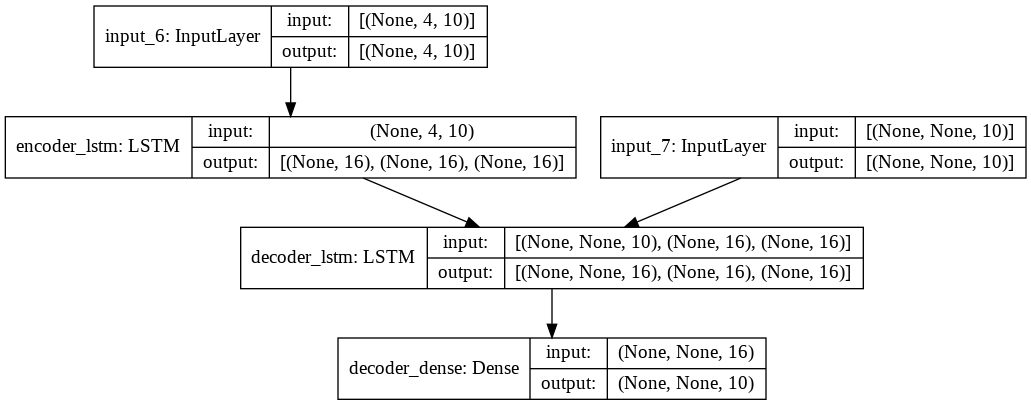

time: 141 ms (started: 2021-01-04 06:40:03 +00:00)


In [103]:


model_encoder_training.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_encoder_training.summary()
plot_model(model_encoder_training, show_shapes=True)



In [104]:
# now create the datset in such a way that teacher forcing is used.
# for that we need to insert "0" as the start token in the target sequence and pop the last entry in the sample.
# tf means teacher forcing
def generate_sequence_tf(length, n_unique):
  vector = [randint(1, n_unique-1) for _ in range(length)]
  # print(vector)
  return vector

# one hot encode sequence
def one_hot_encode_tf(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)

time: 7.52 ms (started: 2021-01-04 06:40:03 +00:00)


In [105]:
# prepare encoder data for the Encoder-Decoder training
def get_encoder_triple(time_steps,vocabulary_size,verbose= False):
# generate random sequence
  sequence_in = generate_sequence_tf(time_steps, vocabulary_size)

  encoder_in = sequence_in.copy()
  

   
  

  decoder_out = sequence_in[::-1]
  
  decoder_in = decoder_out.copy()
  decoder_in.insert(0,0)
  decoder_in.pop()

  # one hot encode
  X_encoder_in = one_hot_encode_tf(encoder_in, vocabulary_size)
  X_decoder_in = one_hot_encode_tf(decoder_in, vocabulary_size)
  y_decoder_out = one_hot_encode_tf(decoder_out, vocabulary_size)
  # reshape as 3D
  X_encoder_in = X_encoder_in.reshape((1, X_encoder_in.shape[0], X_encoder_in.shape[1]))
  X_decoder_in = X_decoder_in.reshape((1, X_decoder_in.shape[0], X_decoder_in.shape[1]))
  y_decoder_out = y_decoder_out.reshape((1, y_decoder_out.shape[0], y_decoder_out.shape[1]))

  if(verbose):
    print('\nSample X_encoder_in X_decoder_in and y_decoder_out')
    print('\nIn raw format:')
    print('X_encoder_in=%s, X_decoder_in=%s, y_decoder_out=%s' % 
          (one_hot_decode_tf(X_encoder_in[0]), one_hot_decode_tf(X_decoder_in[0]), 
           one_hot_decode_tf(y_decoder_out[0])))
    print('\nIn one_hot_encoded format:')
    print('X_encoder_in=%s' % (X_encoder_in[0]))
    print('X_decoder_in=%s' % (X_decoder_in[0]))
    print('y_decoder_out=%s' % (y_decoder_out[0]))
  return [array(X_encoder_in), array(X_decoder_in), array(y_decoder_out)]

time: 18.6 ms (started: 2021-01-04 06:40:03 +00:00)


In [106]:
vocabulary_size=10
time_steps=4

time: 817 µs (started: 2021-01-04 06:40:03 +00:00)


In [107]:
def create_encoder_dataset_tf(train_size, test_size, time_steps, vocabulary_size, verbose= False):
  print("time_steps = {}".format(time_steps))
  print("vocabulary_size = {}".format(vocabulary_size))

  X_encoder_in = list()
  X_decoder_in = list()
  y_decoder_out = list()

  for _ in range(train_size):
    triple=get_encoder_triple(time_steps, vocabulary_size, verbose=False) 
    X_encoder_in.append(triple[0])
    X_decoder_in.append(triple[1])
    y_decoder_out.append(triple[2])

  X_encoder_in= array(X_encoder_in).squeeze()
  X_decoder_in= array(X_decoder_in).squeeze()
  y_decoder_out= array(y_decoder_out).squeeze()
  if(verbose):
    print('\nGenerated sequence datasets as follows')
    print('X_encoder_in.shape: ', X_encoder_in.shape)
    print('X_decoder_in.shape: ', X_decoder_in.shape)
    print('y_decoder_out.shape: ', y_decoder_out.shape)
    print('Sample sequences in raw format:')
    
    print('X_encoder_in: \n', one_hot_decode(X_encoder_in[0]))
    print('X_decoder_in: \n', one_hot_decode(X_decoder_in[0]))
    print('y_decoder_out: \n',one_hot_decode(y_decoder_out[0]))

    print('Sample sequences in one-hot encoded format:')
    print('X_encoder_in: \n', X_encoder_in[0])
    print('X_decoder_in: \n', X_decoder_in[0])
    print('y_decoder_out: \n', y_decoder_out[0])

  return X_encoder_in, X_decoder_in, y_decoder_out

time: 22.2 ms (started: 2021-01-04 06:40:03 +00:00)


In [108]:
# Configure problem

n_timesteps_in = 4
#each input sample has 4 values

n_features = 10   
#each value is one_hot_encoded with 10 0/1
#n_timesteps_out = 2  
#each output sample has 2 values padded with 0

# generate random sequence
#X,y = get_reversed_pairs(n_timesteps_in,  n_features, verbose=True)
# generate datasets
train_size= 5000 
test_size = 100  

time: 3.26 ms (started: 2021-01-04 06:40:03 +00:00)


In [109]:
encoder_input_data, decoder_input_data, decoder_predicted_data=\
create_encoder_dataset_tf(train_size, test_size, n_timesteps_in, n_features , verbose=True)

time_steps = 4
vocabulary_size = 10

Generated sequence datasets as follows
X_encoder_in.shape:  (5000, 4, 10)
X_decoder_in.shape:  (5000, 4, 10)
y_decoder_out.shape:  (5000, 4, 10)
Sample sequences in raw format:
X_encoder_in: 
 [9, 1, 2, 4]
X_decoder_in: 
 [0, 4, 2, 1]
y_decoder_out: 
 [4, 2, 1, 9]
Sample sequences in one-hot encoded format:
X_encoder_in: 
 [[0 0 0 0 0 0 0 0 0 1]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]]
X_decoder_in: 
 [[1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]]
y_decoder_out: 
 [[0 0 0 0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1]]
time: 325 ms (started: 2021-01-04 06:40:03 +00:00)


In [110]:
model_encoder_training.fit([encoder_input_data, decoder_input_data], decoder_predicted_data,
          batch_size=32,
          epochs=50,
          validation_split=0.2)

Epoch 1/50
125/125 [==============================] - 3s 10ms/step - loss: 2.2495 - accuracy: 0.1608 - val_loss: 1.9974 - val_accuracy: 0.2960
Epoch 2/50
125/125 [==============================] - 1s 5ms/step - loss: 1.8453 - accuracy: 0.3343 - val_loss: 1.5227 - val_accuracy: 0.4293
Epoch 3/50
125/125 [==============================] - 1s 5ms/step - loss: 1.4344 - accuracy: 0.4665 - val_loss: 1.1908 - val_accuracy: 0.5842
Epoch 4/50
125/125 [==============================] - 1s 5ms/step - loss: 1.1076 - accuracy: 0.6293 - val_loss: 0.8761 - val_accuracy: 0.7795
Epoch 5/50
125/125 [==============================] - 1s 5ms/step - loss: 0.8023 - accuracy: 0.8085 - val_loss: 0.6348 - val_accuracy: 0.8863
Epoch 6/50
125/125 [==============================] - 1s 5ms/step - loss: 0.5866 - accuracy: 0.9067 - val_loss: 0.4705 - val_accuracy: 0.9395
Epoch 7/50
125/125 [==============================] - 1s 6ms/step - loss: 0.4343 - accuracy: 0.9496 - val_loss: 0.3580 - val_accuracy: 0.9628
Epoch

time: 37.6 s (started: 2021-01-04 06:40:03 +00:00)


training for  50  epochs begins with EarlyStopping(monitor= val_loss, patience= 5 )....
Epoch 1/50
141/141 - 2s - loss: 0.0133 - accuracy: 0.9977 - val_loss: 0.0061 - val_accuracy: 1.0000
Epoch 2/50
141/141 - 1s - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 3/50
141/141 - 1s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 4/50
141/141 - 1s - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0035 - val_accuracy: 1.0000
Epoch 5/50
141/141 - 1s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 6/50
141/141 - 1s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 7/50
141/141 - 1s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 8/50
141/141 - 1s - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 9/50
141/141 - 1s - loss: 0.0023 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 10/50


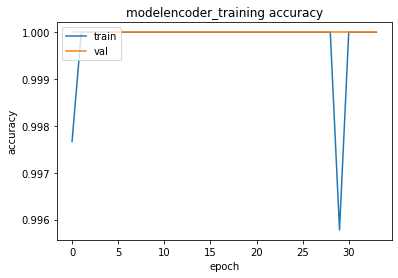

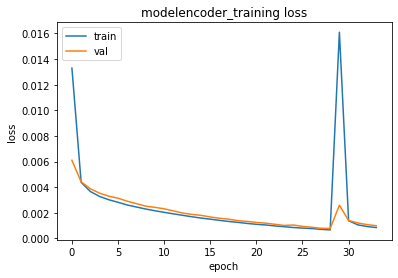

10 examples from test data...
Input          Expected       Predicted         T/F
[9, 1, 2, 4]   [4, 2, 1, 9]   [4, 2, 1, 9]   True
[2, 5, 4, 5]   [5, 4, 5, 2]   [5, 4, 5, 2]   True
[4, 6, 7, 4]   [4, 7, 6, 4]   [4, 7, 6, 4]   True
[3, 6, 7, 2]   [2, 7, 6, 3]   [2, 7, 6, 3]   True
[9, 5, 7, 1]   [1, 7, 5, 9]   [1, 7, 5, 9]   True
[2, 3, 3, 5]   [5, 3, 3, 2]   [5, 3, 3, 2]   True
[7, 2, 1, 5]   [5, 1, 2, 7]   [5, 1, 2, 7]   True
[7, 9, 3, 2]   [2, 3, 9, 7]   [2, 3, 9, 7]   True
[8, 9, 7, 2]   [2, 7, 9, 8]   [2, 7, 9, 8]   True
[7, 9, 3, 2]   [2, 3, 9, 7]   [2, 3, 9, 7]   True
Accuracy:  1.0
time: 31.2 s (started: 2021-01-04 06:40:41 +00:00)


In [111]:


train_test(model_encoder_training, [encoder_input_data, decoder_input_data], decoder_predicted_data , [encoder_input_data, decoder_input_data], decoder_predicted_data, epochs=50, batch_size=32, patience=5,verbose=2)



In [112]:
# encoder decoder model using teacher forcing with inference

# create an encoder model separately
encoder_model = Model(encoder_inputs, encoder_states)

time: 7.09 ms (started: 2021-01-04 07:01:27 +00:00)


In [113]:
encoder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 4, 10)]           0         
_________________________________________________________________
encoder_lstm (LSTM)          [(None, 16), (None, 16),  1728      
Total params: 1,728
Trainable params: 1,728
Non-trainable params: 0
_________________________________________________________________
time: 4.07 ms (started: 2021-01-04 07:01:44 +00:00)


In [114]:
# create decoder model separately
decoder_state_input_h = Input(shape=(LSTMoutputDimension,))
decoder_state_input_c = Input(shape=(LSTMoutputDimension,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

time: 219 ms (started: 2021-01-04 07:07:20 +00:00)


In [120]:


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    print("states_value output of encoder_model predict method = {}".format(states_value))

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, n_features))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, 0] = 1

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_seq = list()
    while not stop_condition:

        # in a loop
        # decode the input to a token/output prediction + required states for context vector
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # convert the token/output prediction to a token/output
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_digit = sampled_token_index
        # add the predicted token/output to output sequence
        decoded_seq.append(sampled_digit)
        

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_digit == '\n' or
           len(decoded_seq) == n_timesteps_in):
            stop_condition = True

        # Update the input target sequence (of length 1) 
        # with the predicted token/output 
        target_seq = np.zeros((1, 1, n_features))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update input states (context vector) 
        # with the ouputed states
        states_value = [h, c]

        # loop back.....
        
    # when loop exists return the output sequence
    return decoded_seq



time: 16.2 ms (started: 2021-01-04 07:34:38 +00:00)


In [121]:
print('Input \t\t\t  Expected  \t   Predicted \t\tT/F')
correct =0 
sampleNo =  10
for sample in range(0,sampleNo):
  predicted= decode_sequence(encoder_input_data[sample].reshape(1,n_timesteps_in,n_features))
  if (one_hot_decode(decoder_predicted_data[sample])== predicted):
    correct+=1
  print( one_hot_decode(encoder_input_data[sample]), '\t\t', 
        one_hot_decode(decoder_predicted_data[sample]),'\t', predicted,
        '\t\t',one_hot_decode(decoder_predicted_data[sample])== predicted)
print('Accuracy: ', correct/sampleNo)

Input 			  Expected  	   Predicted 		T/F
states_value output of encoder_model predict method = [array([[ 0.15404575,  0.11487242, -0.07334545,  0.17666449, -0.20113322,
         0.34758753, -0.1699705 , -0.16558307, -0.22649814,  0.4870121 ,
         0.46270818, -0.46178216, -0.27263325, -0.10083079, -0.23996384,
        -0.30643398]], dtype=float32), array([[ 0.2633715 ,  0.20769882, -0.14942573,  0.24140748, -0.32320493,
         0.62191445, -0.3069097 , -0.30623588, -0.40250912,  0.64367443,
         1.0230473 , -0.71835655, -0.4603724 , -0.291624  , -0.53072923,
        -0.44050956]], dtype=float32)]
[9, 1, 2, 4] 		 [4, 2, 1, 9] 	 [4, 2, 1, 9] 		 True
states_value output of encoder_model predict method = [array([[ 0.24426755, -0.19595313,  0.05590463,  0.3387951 , -0.27155596,
         0.6391877 , -0.38931665, -0.11040268, -0.42338082,  0.07646326,
         0.40490523,  0.03448637, -0.39045534, -0.32512194,  0.00322371,
        -0.07948167]], dtype=float32), array([[ 0.40146452, -0